# Load data

In [54]:
import pandas as pd
from pathlib import Path

base_folder = Path.cwd()


sample_files = ['sample_1.csv', 'sample_2.csv', 'sample_3.csv', 'sample_4.csv']
data = {}

for folder in [f for f in base_folder.iterdir() if f.is_dir()]:
    data[folder.name] = {}
    for sample_file in sample_files:
        file_path = folder / sample_file
        if file_path.exists():
            df = pd.read_csv(file_path, encoding='utf-8-sig')  # handles BOM if present
            # Normalize column names: strip spaces and BOM, unify case
            df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)
            data[folder.name][sample_file] = df


# Containers for data and weights
data = {}
weights = {}

# Helper function to read weights.txt into a dictionary
def read_weights(file_path):
    w = {}
    with open(file_path, 'r') as f:
        for line in f:
            if ";" in line:
                key, value = line.strip().split(";")
                key = key.strip().lower().replace("sample", "sample_") + ".csv"
                value = float(value.strip().replace("grams", "").strip())
                w[key] = value
    return w

# First, load healthy dataset weights for delta comparison
healthy_folder = base_folder / "healthydataset"
healthy_weights = read_weights(healthy_folder / "weights.txt")

# Now process all folders
for folder in [f for f in base_folder.iterdir() if f.is_dir()]:
    folder_name = folder.name
    data[folder_name] = {}
    weights[folder_name] = {}
    
    # Read weights
    weight_file = folder / "weights.txt"
    if weight_file.exists():
        current_weights = read_weights(weight_file)
        for sample_file in sample_files:
            if sample_file in current_weights:
                delta = current_weights[sample_file] - healthy_weights.get(sample_file, 0.0)
                weights[folder_name][sample_file] = delta
    
    # Read sample data
    for sample_file in sample_files:
        file_path = folder / sample_file
        if file_path.exists():
            df = pd.read_csv(file_path, encoding='utf-8-sig')
            df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)
            data[folder_name][sample_file] = df


In [55]:
import pandas as pd
from pathlib import Path

base_folder = Path.cwd()
sample_files = ['sample_1.csv', 'sample_2.csv', 'sample_3.csv', 'sample_4.csv']

# Read weights.txt helper
def read_weights(file_path):
    w = {}
    with open(file_path, 'r') as f:
        for line in f:
            if ";" in line:
                key, value = line.strip().split(";")
                key = key.strip().lower().replace("sample", "sample_") + ".csv"
                value = float(value.strip().replace("grams", "").strip())
                w[key] = value
    return w

# Load healthy weights
healthy_folder = base_folder / "healthydataset"
healthy_weights = read_weights(healthy_folder / "weights.txt")

# Collect all sample data into a flat DataFrame
rows = []

for folder in [f for f in base_folder.iterdir() if f.is_dir()]:
    folder_name = folder.name
    weight_file = folder / "weights.txt"
    current_weights = read_weights(weight_file) if weight_file.exists() else {}

    for sample_file in sample_files:
        file_path = folder / sample_file
        if file_path.exists():
            # Load data
            df = pd.read_csv(file_path, encoding='utf-8-sig')
            df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)

            # Delta weight
            delta_weight = current_weights.get(sample_file, None)
            if sample_file in healthy_weights and delta_weight is not None:
                delta_weight -= healthy_weights.get(sample_file, 0.0)

            # Store each row with metadata
            for _, row in df.iterrows():
                row_data = row.to_dict()
                row_data['folder'] = folder_name
                row_data['sample_file'] = sample_file
                row_data['delta_weight'] = delta_weight
                rows.append(row_data)

# Final DataFrame for easy analysis
combined_data = pd.DataFrame(rows)


# PLOT DATA

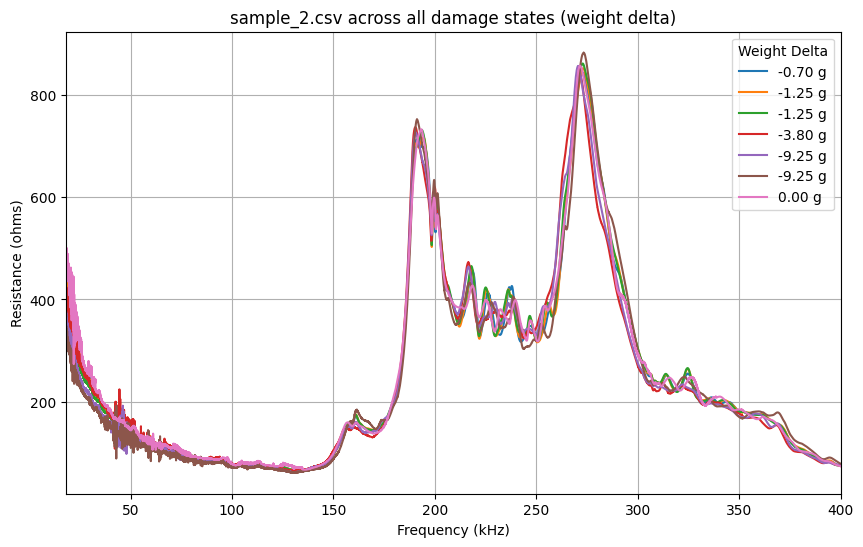

In [56]:
import matplotlib.pyplot as plt

sample_to_plot = "sample_2.csv"

plt.figure(figsize=(10, 6))

for folder_name, samples in data.items():
    if sample_to_plot in samples:
        df = samples[sample_to_plot]
        # Get the delta weight label, format nicely (e.g. 2 decimals)
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        label = f"{delta_weight:.2f} g" if delta_weight is not None else folder_name
        
        plt.plot(
            df["Frequency (Hz)"]/1000,
            df["Resistance (ohms)"],
            label=label
        )

plt.xlabel("Frequency (kHz)")
plt.ylabel("Resistance (ohms)")
plt.title(f"{sample_to_plot} across all damage states (weight delta)")
plt.legend(title="Weight Delta")
plt.grid(True)
plt.xlim(18,400)
plt.show()



# RMSD function

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def compute_rmsd_from_dfs_simple(dfs, f_min, f_max, label):
    freqs = dfs[0]["Frequency (Hz)"].values
    mask = (freqs >= f_min) & (freqs <= f_max)
    freqs_kHz = freqs[mask] / 1000

    def normalize(arr):
        return (arr - arr.min()) / (arr.max() - arr.min())

    Z_ref = normalize(dfs[-1]["Resistance (ohms)"].values[mask])

    rmsd_list = []
    plt.figure(figsize=(10, 6))
    for i, df in enumerate(dfs):
        Z = normalize(df["Resistance (ohms)"].values[mask])
        rmsd = np.sqrt(np.mean((Z - Z_ref) ** 2))
        rmsd_list.append(rmsd)
        plt.plot(freqs_kHz, Z, label=str(label[i]))


    plt.xlabel("Frequency (kHz)")
    plt.ylabel("Normalized Resistance")
    plt.title("Normalized Resistance in Frequency Band")
    plt.grid(True)
    plt.legend()
    plt.show()

    return np.array(rmsd_list)


## Test RMSD

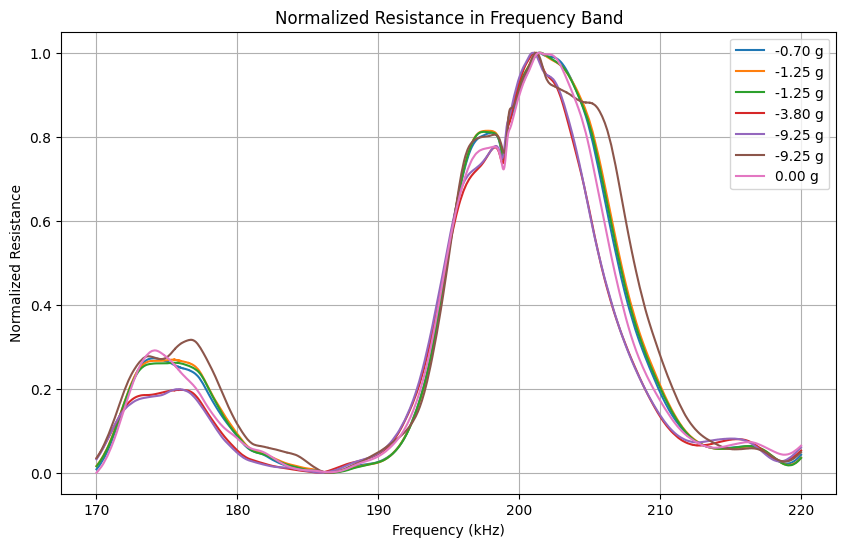

[0.02173932 0.03152481 0.02768094 0.04741285 0.04808134 0.07457356
 0.        ]


In [58]:
sample_to_plot = "sample_1.csv"
f_min, f_max = 170000, 220000

dfs_for_sample = [
    samples[sample_to_plot]
    for folder_name, samples in data.items()
    if sample_to_plot in samples
]

labels = []
for folder_name, samples in data.items():
    if sample_to_plot in samples:
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        if delta_weight is not None:
            labels.append(f"{delta_weight:.2f} g")
        else:
            labels.append(folder_name)

rmsd_values = compute_rmsd_from_dfs_simple(dfs_for_sample, f_min, f_max, labels)

print(rmsd_values)

# CCD Function

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def compute_corr_dev_from_dfs_simple(dfs, f_min, f_max, label):
    freqs = dfs[0]["Frequency (Hz)"].values
    mask = (freqs >= f_min) & (freqs <= f_max)
    freqs_kHz = freqs[mask] / 1000

    def normalize(arr):
        return (arr - arr.min()) / (arr.max() - arr.min())

    Z_ref = normalize(dfs[-1]["Resistance (ohms)"].values[mask])

    corr_dev_list = []
    plt.figure(figsize=(10, 6))
    for i, df in enumerate(dfs):
        Z = normalize(df["Resistance (ohms)"].values[mask])
        corr_coef = np.corrcoef(Z, Z_ref)[0, 1]  # Pearson correlation coefficient
        corr_dev = 1 - corr_coef
        corr_dev_list.append(corr_dev)
        plt.plot(freqs_kHz, Z, label=str(label[i]))

    plt.xlabel("Frequency (kHz)")
    plt.ylabel("Normalized Resistance")
    plt.title("Normalized Resistance in Frequency Band")
    plt.grid(True)
    plt.legend()
    plt.show()

    return np.array(corr_dev_list)

## Test CCD Function

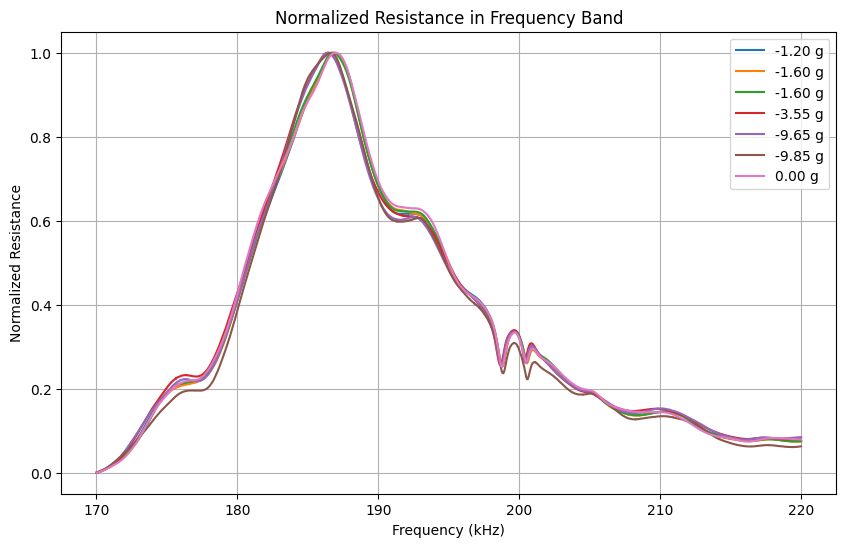

[3.58512397e-04 2.98855714e-04 3.75946416e-04 2.05212775e-03
 2.27481207e-03 2.59802349e-03 2.22044605e-16]


In [60]:
sample_to_plot = "sample_4.csv"
f_min, f_max = 170000, 220000

dfs_for_sample = [
    samples[sample_to_plot]
    for folder_name, samples in data.items()
    if sample_to_plot in samples
]

labels = []
for folder_name, samples in data.items():
    if sample_to_plot in samples:
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        if delta_weight is not None:
            labels.append(f"{delta_weight:.2f} g")
        else:
            labels.append(folder_name)

CCD_values = compute_corr_dev_from_dfs_simple(dfs_for_sample, f_min, f_max, labels)

print(CCD_values)

# Get RMSD and CCD

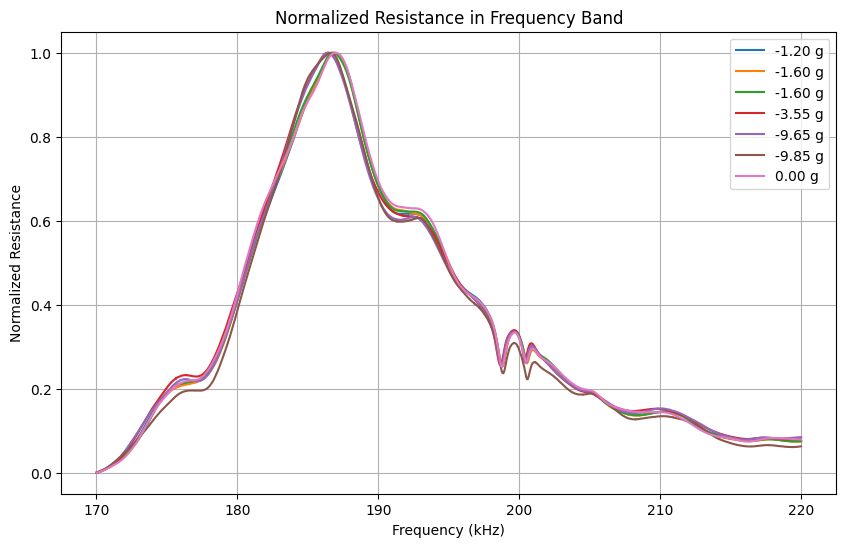

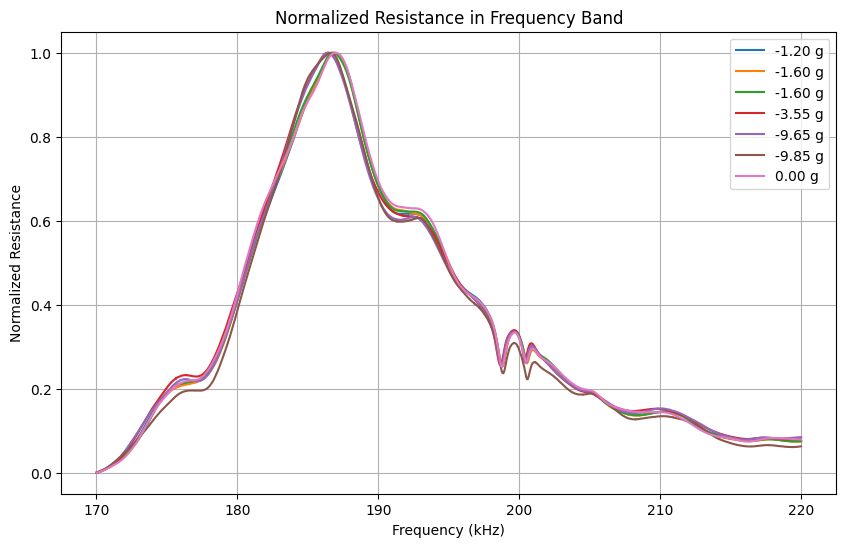

In [61]:
sample_to_plot = "sample_4.csv"
f_min, f_max = 170000, 220000

dfs_for_sample = [
    samples[sample_to_plot]
    for folder_name, samples in data.items()
    if sample_to_plot in samples
]

labels = []
for folder_name, samples in data.items():
    if sample_to_plot in samples:
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        if delta_weight is not None:
            labels.append(f"{delta_weight:.2f} g")
        else:
            labels.append(folder_name)

rmsd_values = compute_rmsd_from_dfs_simple(dfs_for_sample, f_min, f_max, labels)

CCD_values = compute_corr_dev_from_dfs_simple(dfs_for_sample, f_min, f_max, labels)

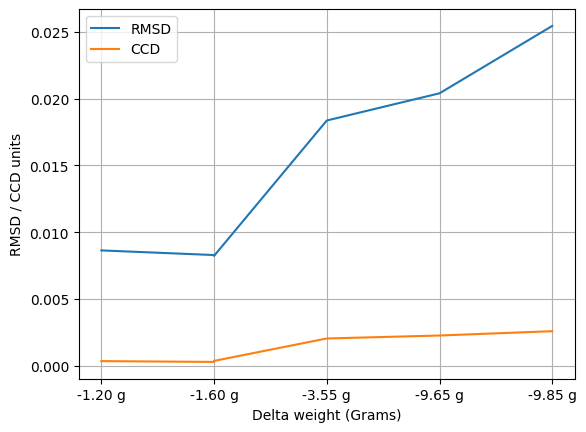

In [62]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Plot all except the last value which is the original, healthy dataset
ax1.plot(labels[:-1], rmsd_values[:-1], label='RMSD')
ax1.plot(labels[:-1],CCD_values[:-1], label='CCD')
ax1.set_ylabel('RMSD / CCD units')
ax1.legend(loc='upper left')
ax1.set_xlabel('Delta weight (Grams)')
plt.grid()
plt.show()


# Estimate Q factor

In [63]:
import numpy as np

# Assume f_band and Z_meas_band.real are numpy arrays

sample4 = combined_data[combined_data["sample_file"] == "sample_4.csv"]
f_band = sample4["Frequency (Hz)"].values
Z_meas_band = sample4["Resistance (ohms)"].values



def estimate_q_factor(f_band, Z_real):
    peak_idx = np.argmax(Z_real)
    f0 = f_band[peak_idx]
    peak_val = Z_real[peak_idx]
    half_power = peak_val / np.sqrt(2)
    
    # Find lower frequency at half power
    lower_idx = np.where(Z_real[:peak_idx] <= half_power)[0]
    if len(lower_idx) == 0:
        f1 = f_band[0]
    else:
        f1 = f_band[lower_idx[-1]]
    
    # Find higher frequency at half power
    upper_idx = np.where(Z_real[peak_idx:] <= half_power)[0]
    if len(upper_idx) == 0:
        f2 = f_band[-1]
    else:
        f2 = f_band[peak_idx + upper_idx[0]]
    
    bandwidth = f2 - f1
    Q = f0 / bandwidth if bandwidth != 0 else np.inf
    
    print(f"Resonant frequency f0 = {f0/1e3:.2f} kHz")
    print(f"Bandwidth Δf = {bandwidth/1e3:.2f} kHz")
    print(f"Estimated Q factor = {Q:.2f}")
    return Q

estimate_q_factor(df["Frequency (Hz)"]/1000, df["Resistance (ohms)"])



Resonant frequency f0 = 0.27 kHz
Bandwidth Δf = 0.02 kHz
Estimated Q factor = 15.36


np.float64(15.358863678940194)

Resonant frequency f0 = 271.58 kHz
Bandwidth Δf = 85.61 kHz
Estimated Q factor = 3.17


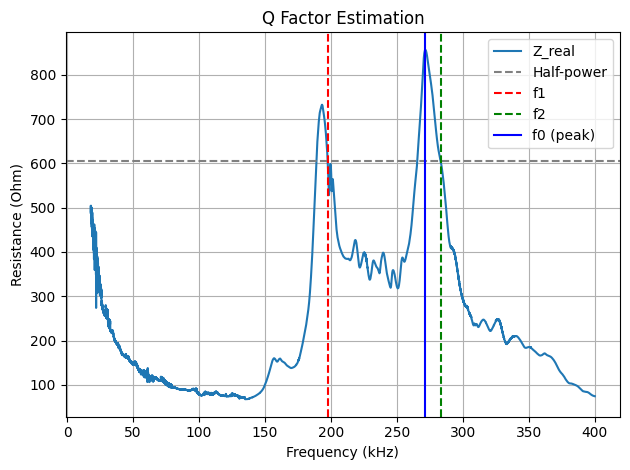

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

#df = pd.read_csv("sample_1.csv", encoding="utf-8-sig")
#df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)

f_band = df.iloc[:, 0].values  # First column: frequencies
Z_real = df.iloc[:, 1].values  # Second column: real part of Resistance


def estimate_q_factor(f_band, Z_real, plot=False):
    f_band = np.array(f_band)
    Z_real = np.array(Z_real)

    peak_idx = np.argmax(Z_real)
    f0 = f_band[peak_idx]
    peak_val = Z_real[peak_idx]
    half_power = peak_val / np.sqrt(2)

    # Interpolation function
    interp = interp1d(f_band, Z_real, kind='cubic', bounds_error=False, fill_value="extrapolate")

    # Find lower half-power point
    lower_freqs = f_band[:peak_idx]
    lower_vals = Z_real[:peak_idx]
    f1 = f_band[0]
    for i in reversed(range(1, len(lower_vals))):
        if lower_vals[i] < half_power and lower_vals[i-1] > half_power:
            f1 = interp1d(lower_vals[i-1:i+1], lower_freqs[i-1:i+1])(half_power)
            break

    # Find upper half-power point
    upper_freqs = f_band[peak_idx:]
    upper_vals = Z_real[peak_idx:]
    f2 = f_band[-1]
    for i in range(1, len(upper_vals)):
        if upper_vals[i] < half_power and upper_vals[i-1] > half_power:
            f2 = interp1d(upper_vals[i-1:i+1], upper_freqs[i-1:i+1])(half_power)
            break

    bandwidth = f2 - f1
    Q = f0 / bandwidth if bandwidth != 0 else np.inf

    print(f"Resonant frequency f0 = {f0/1e3:.2f} kHz")
    print(f"Bandwidth Δf = {bandwidth/1e3:.2f} kHz")
    print(f"Estimated Q factor = {Q:.2f}")

    if plot:
        plt.figure()
        plt.plot(f_band / 1e3, Z_real, label='Z_real')
        plt.axhline(half_power, color='gray', linestyle='--', label='Half-power')
        plt.axvline(f1 / 1e3, color='red', linestyle='--', label='f1')
        plt.axvline(f2 / 1e3, color='green', linestyle='--', label='f2')
        plt.axvline(f0 / 1e3, color='blue', linestyle='-', label='f0 (peak)')
        plt.xlabel("Frequency (kHz)")
        plt.ylabel("Resistance (Ohm)")
        plt.title("Q Factor Estimation")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return Q

Q = estimate_q_factor(f_band, Z_real, plot=True)


In [65]:
print(combined_data["Frequency (Hz)"])

0          18000.0000
1          18010.0125
2          18020.0250
3          18030.0375
4          18040.0500
             ...     
801250    399976.5875
801251    399986.6000
801252    399996.6125
801253    400006.6250
801254    400016.6375
Name: Frequency (Hz), Length: 801255, dtype: float64


# Parameter estimation

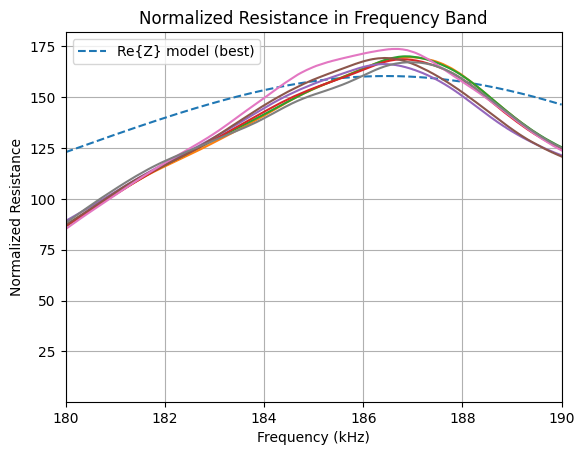

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# --- Model ---
def model_Z(f, R1, L1, C1, C0):
    w = 2 * np.pi * f
    Zs = R1 + 1j*w*L1 + 1/(1j*w*C1)   # series RLC
    Y_total = 1j*w*C0 + 1/Zs          # parallel C0
    return 1 / Y_total

def mechanical_params_from_electrical(f, R1, L1, C1, C0):
    b1 = R1
    m1 = L1
    k1 = 1 / C1 if C1 != 0 else float('inf')  # Avoid division by zero
    k0 = 1 / C0 if C0 != 0 else float('inf')
    
    return {'b1': b1, 'm1': m1, 'k1': k1, 'k0': k0}

sample4 = combined_data[combined_data["sample_file"] == "sample_4.csv"]
f_band = sample4["Frequency (Hz)"].values
Z_meas_band = sample4["Resistance (ohms)"].values

f_band = np.array(np.linspace(150000, 230000, 50000))

# --- Initial guesses (from you) ---
R1 = 130.0        # Ohms
L1 = 900e-6       # H
C1 = 0.93e-9      # F
C0 = 5.9e-9       # F

# --- Naive nested loops ---
Z_fit = model_Z(f_band, R1, L1, C1, C0)
# --- Plot ---
plt.figure()
plt.plot(f_band/1000, Z_fit.real, '--', label="Re{Z} model (best)")


f_min = min(f_band)
f_max = max(f_band)
freqs = dfs_for_sample[0]["Frequency (Hz)"].values
mask = (freqs >= f_min) & (freqs <= f_max)
freqs_kHz = freqs[mask] / 1000
for i, df in enumerate(dfs_for_sample):
    Z = (df["Resistance (ohms)"].values[mask])
    plt.plot(freqs_kHz, Z)


plt.xlabel("Frequency (kHz)")
plt.ylabel("Normalized Resistance")
plt.title("Normalized Resistance in Frequency Band")
plt.grid(True)
plt.legend()
plt.xlim(180, 190)
plt.show()

# New plotting

Best MSE: 2340.269878048676
Best C1: 8.990816326530612e-10 F


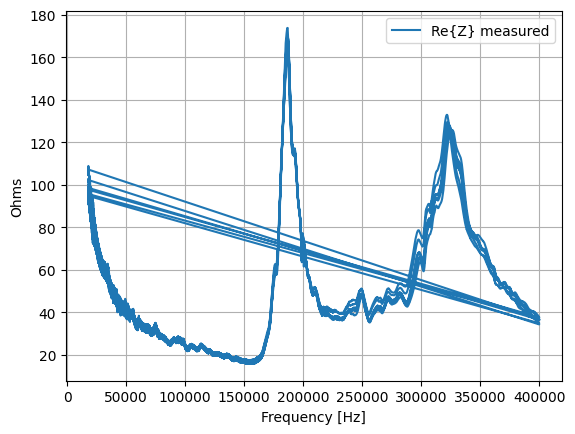

In [67]:

import numpy as np
from sklearn.metrics import mean_squared_error

# --- Initial guesses ---
param_guesses = {
    'R1': 155.0,         # Ohm
    'L1': 900e-6,        # H
    'C1': 0.89e-9,       # F
    'C0': 5.9e-9         # F
}

# --- Model function ---
def model_Z(f, R1, L1, C1, C0):
    w = 2 * np.pi * f
    Zs = R1 + 1j*w*L1 + 1/(1j*w*C1)
    Y_total = 1j*w*C0 + 1/Zs
    return 1 / Y_total

f_band = sample4["Frequency (Hz)"].values
Z_meas_band = sample4["Resistance (ohms)"].values

# --- Optimizer function ---
def optimize_single_param(f_band, Z_meas_band, param_name, num_points=50, scale=0.5):
    if param_name not in param_guesses:
        raise ValueError(f"Invalid parameter: {param_name}")

    # Get initial values
    base_params = param_guesses.copy()
    base_value = base_params[param_name]
    
    # Create grid for the selected parameter
    param_grid = np.linspace(base_value * (1 - scale), base_value * (1 + scale), num_points)

    best_mse = np.inf
    best_value = base_value

    for val in param_grid:
        params = base_params.copy()
        params[param_name] = val
        Z_fit = model_Z(f_band, **params)
        mse = mean_squared_error(Z_meas_band.real, Z_fit.real)
        if mse < best_mse:
            best_mse = mse
            best_value = val

    return best_mse, best_value


# Example usage:
best_mse, best_C1 = optimize_single_param(f_band, Z_meas_band, 'C1')
print(f"Best MSE: {best_mse}")
print(f"Best C1: {best_C1} F")

# --- Plot ---
plt.figure()
plt.plot(f_band, Z_meas_band.real, label="Re{Z} measured")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Ohms")
plt.legend()
plt.grid(True)
plt.show()


# BVD

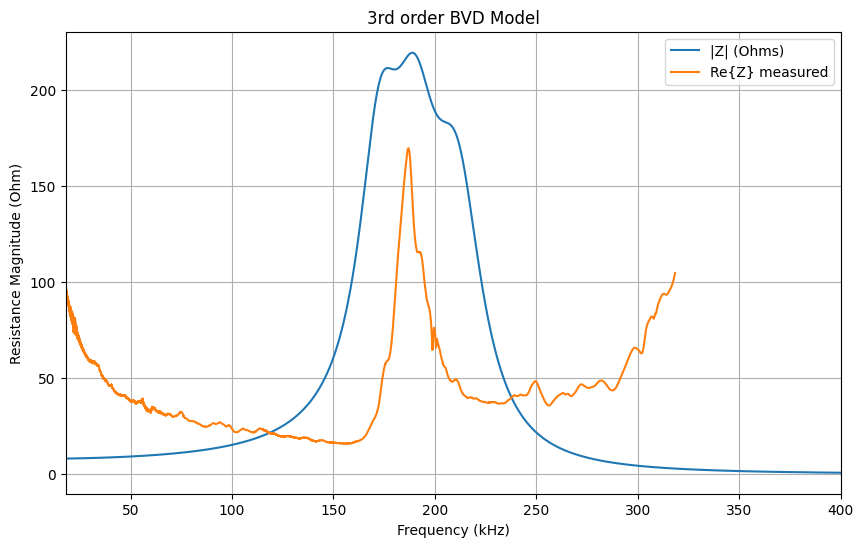

In [68]:
import numpy as np
import matplotlib.pyplot as plt

f_band = sample4["Frequency (Hz)"].values
Z_meas_band = sample4["Resistance (ohms)"].values

def butterworth_van_dyke(f, Rm, Cm, Lm, C0):
    w = 2 * np.pi * f
    Zm = Rm + 1j*w*Lm + 1/(1j*w*Cm)
    Y_total = 1j*w*C0 + 1/Zm
    return 1 / Y_total


# --- Initial guesses ---
param_guesses = {
    'R1': 155.0,         # Ohm
    'L1': 900e-6,        # H
    'C1': 0.89e-9,       # F
    'C0': 5.9e-9         # F
}


f = np.linspace(18e3, 400e3, 50000)
Z1 = butterworth_van_dyke(f, param_guesses["R1"], param_guesses["C1"], param_guesses["L1"], param_guesses["C0"])
Z2 = butterworth_van_dyke(f, param_guesses["R1"], param_guesses["C1"]*1.1, param_guesses["L1"]*1.1, param_guesses["C0"]*1.1)
Z3 = butterworth_van_dyke(f, param_guesses["R1"], param_guesses["C1"]*0.9, param_guesses["L1"]*0.9, param_guesses["C0"]*0.9)

Z = Z1 + Z2 + Z3

plt.figure(figsize=(10,6))
plt.plot(f/1e3, np.real(Z), label='|Z| (Ohms)')
plt.plot(f_band[1:30000]/1e3, Z_meas_band[1:30000], label="Re{Z} measured")
plt.xlabel('Frequency (kHz)')
plt.ylabel('Resistance Magnitude (Ohm)')
plt.title(f'3rd order BVD Model')
plt.grid(True)
plt.legend()
plt.xlim(18, 400)
plt.show()


## Try to fit BVD model

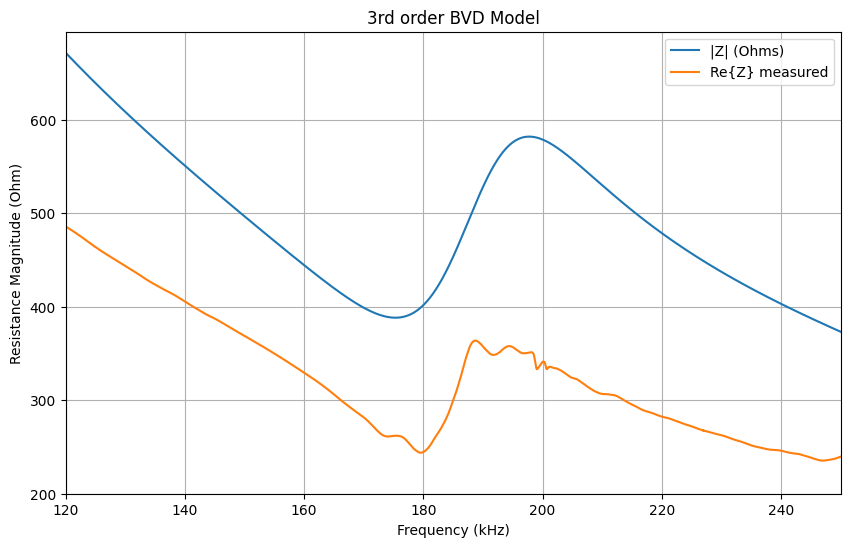

In [72]:
import numpy as np
import matplotlib.pyplot as plt

f_band = sample4["Frequency (Hz)"].values
Z_meas_band = sample4["Resistance (ohms)"].values
Z_meas_imag = sample4["Reactance (ohms)"].values

Z_meas_band = Z_meas_band +1j * Z_meas_imag

def butterworth_van_dyke(f, Rm, Cm, Lm, C0):
    w = 2 * np.pi * f
    Zm = Rm + 1j*w*Lm + 1/(1j*w*Cm)
    Y_total = 1j*w*C0 + 1/Zm
    return 1 / Y_total


# --- Initial guesses ---
param_guesses = {
    'R1': 155.0,         # Ohm
    'L1': 900e-6,        # H
    'C1': 0.89e-9,       # F
    'C0': 5.9e-9         # F
}


f = np.linspace(120e3, 250e3, 50000)
Z1 = butterworth_van_dyke(f, param_guesses["R1"]*1, param_guesses["C1"]*1, param_guesses["L1"]*1, param_guesses["C0"]*1)
Z2 = butterworth_van_dyke(f, param_guesses["R1"]*0.6, param_guesses["C1"]*0.6, param_guesses["L1"]*0.6, param_guesses["C0"]*0.6)
Z3 = butterworth_van_dyke(f, param_guesses["R1"]*1, param_guesses["C1"]*1, param_guesses["L1"]*1, param_guesses["C0"]*1)

Z = Z1 + Z2 + Z3

plt.figure(figsize=(10,6))
plt.plot(f/1e3, np.abs(Z), label='|Z| (Ohms)')
plt.plot(f_band[10000:24000]/1e3, np.abs(Z_meas_band[10000:24000]), label="Re{Z} measured")
plt.xlabel('Frequency (kHz)')
plt.ylabel('Resistance Magnitude (Ohm)')
plt.title(f'3rd order BVD Model')
plt.grid(True)
plt.legend()
plt.xlim(120, 250)
plt.show()
